<a href="https://colab.research.google.com/github/Alexjmsherman/nlp_practicum_cohort3_instructor/blob/master/lessons/lesson_4_dimensionality_reduction/Dimensionality%20Reduction%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dimensionality Reduction Solution

###### Author: Alex Sherman | alsherman@deloitte.com


##### Agenda
- Vector Space Model
- PCA
- SVD
- Latent semantic indexing (LSI/LSA)
- Latent dirichlet allocation (LDA)

In [59]:
# INSTALLATION:

!pip install pyldavis

In [0]:
from collections import defaultdict, Counter
from configparser import ConfigParser, ExtendedInterpolation
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import DiffMetric
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis  # conda install pyldavis
import pyLDAvis.gensim
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline

In [0]:
GENSIM_DICTIONARY_PATH = r'gensim_dictionary_path.txt' 
GENSIM_CORPUS_PATH = r'gensim_corpus_path.txt'
CLEANED_TEXT_PATH = r'https://raw.githubusercontent.com/Alexjmsherman/nlp_practicum_cohort3_instructor/master/raw_data/cleaned_text/cleaned_text.txt?token=ABXRUPRBRDMYTO7MBA77IAK47MCOK'

In [62]:
texts = pd.read_csv(CLEANED_TEXT_PATH, sep='\t')
texts = [line[0].split() for line in texts.values]
texts[0]

['gluten', 'and', 'lymphocytes', 'in', 'coeliac_disease']

# Text Vectorization (gensim)

In [63]:
gensim_url = r'https://radimrehurek.com/gensim/index.html'
iframe = '<iframe src={} width=950 height=300></iframe>'.format(gensim_url)
HTML(iframe)

In [0]:
from gensim import corpora

example_text = [['computer','human', 'interface']]

# fit dictionary
# documents: Documents that used for initialization
# prune_at:  Dictionary will keep not more than prune_at words
dct = corpora.Dictionary(example_text, prune_at=2000000)  

# update dictionary with new documents - useful if text corpora doesn't fit in memory
dct.add_documents([['data','science']])

In [65]:
# view the id associated with each word
dct.token2id

{'computer': 0, 'data': 3, 'human': 1, 'interface': 2, 'science': 4}

In [66]:
# doc2bow returns the (id, count)
dct.doc2bow(["computer"])

[(0, 1)]

In [67]:
# doc2bow returns the (id, count)
dct.doc2bow(["computer","computer"])

[(0, 2)]

In [68]:
# doc2bow returns the (id, count) and can include out of bag OOB vocabulary
dct.doc2bow(["computer", "human", "data", "non_existent_word"], return_missing=True)

([(0, 1), (1, 1), (3, 1)], {'non_existent_word': 1})

Here we assigned a unique integer ID to all words appearing in the processed corpus with the gensim.corpora.dictionary.Dictionary class. 

This sweeps across the texts, collecting word counts and relevant statistics. In the end, we see distinct words in the processed corpus, which means each document will be represented by n numbers (ie., by a n-D vector).

In [69]:
# turn our tokenized documents into a id <-> term dictionary

dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(15696 unique tokens: ['and', 'coeliac_disease', 'gluten', 'in', 'lymphocytes']...)


In [70]:
# num_docs – number of documents processe
print('num docs: {}'.format(dictionary.num_docs))

# num_pos – total number of  processed words
print('num pos: {}'.format(dictionary.num_pos))

num docs: 12446
num pos: 239539


##### filter_extremes

- **no_below (int, optional)** – Keep tokens which are contained in at least no_below documents.
- **no_above (float, optional)** – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n (int, optional)** – Keep only the first keep_n most frequent tokens.
- **keep_tokens (iterable of str)** – Iterable of tokens that must stay in dictionary after filtering.

In [0]:
# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=.01, no_above=0.99, keep_n=10000)

In [72]:
print(dictionary.token2id)

{'and': 0, 'coeliac_disease': 1, 'gluten': 2, 'in': 3, 'lymphocytes': 4, 'activity': 5, 'best': 6, 'concentrations': 7, 'correlated': 8, 'disease': 9, 'duration': 10, 'gamma_globulin': 11, 'of': 12, 'or': 13, 'protein': 14, 'rather': 15, 'severity': 16, 'than': 17, 'the': 18, 'this': 19, 'total': 20, 'with': 21, 'affect': 22, 'appear': 23, 'but': 24, 'cardiac': 25, 'control': 26, 'do': 27, 'evidence': 28, 'exists': 29, 'including': 30, 'increased': 31, 'itself': 32, 'manifestations': 33, 'nervousness': 34, 'not': 35, 'output': 36, 'palpitations': 37, 'peripheral': 38, 'process': 39, 'some': 40, 'tachycardia': 41, 'that': 42, 'they': 43, 'thyrotoxic': 44, 'to': 45, 'tremor': 46, 'underlying': 47, 'additional': 48, 'against': 49, 'agent': 50, 'antigens': 51, 'cf': 52, 'finding': 53, 'for': 54, 'have': 55, 'hrvl': 56, 'human': 57, 'implications': 58, 'may': 59, 'substitute': 60, 'cancer': 61, 'colonic': 62, 'digestive_tract': 63, 'essentially': 64, 'found': 65, 'most': 66, 'patients': 67,

##### doc2bow()
The function doc2bow() counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a bag-of-words--a sparse vector, in the form of [(word_id, word_count), ...].

For people familiar with scikit learn, doc2bow() has similar behaviors as calling transform() on CountVectorizer. doc2bow() can behave like fit_transform() as well. For more details, please look at gensim API Doc.

In [73]:
# map two documents using doc to bag of words

print('Document 0: {}'.format(texts[0]))
print(dictionary.doc2bow(texts[0]))

print('\nDocument 1: {}'.format(texts[1]))
print(dictionary.doc2bow(texts[1]))

Document 0: ['gluten', 'and', 'lymphocytes', 'in', 'coeliac_disease']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

Document 1: ['this', 'activity', 'correlated', 'best', 'with', 'the', 'severity', 'and', 'duration', 'of', 'the', 'disease', 'rather', 'than', 'with', 'gamma_globulin', 'or', 'total', 'protein', 'concentrations']
[(0, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2)]


In [74]:
# notice that 'in' appears in both documents and is mapped to the same id
print(dictionary[0])

# the second number in each tuple is the count
print(dictionary.doc2bow(['disease']))

and
[(9, 1)]


In [75]:
# convert tokenized documents into a document-term matrix in a sparse representation
corpus = [dictionary.doc2bow(sent) for sent in texts]
print('Sentence 1 BOW:\n {}\n'.format(corpus[0]))
print('Sentence 2 BOW:\n {}'.format(corpus[1]))

Sentence 1 BOW:
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]

Sentence 2 BOW:
 [(0, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2)]


In [76]:
# initialize a tfidf model (similary to TfidfTransformer from sklearn)
tfidf = models.TfidfModel(corpus)
print('TFIDF for sentent 0:\n {}\n'.format(tfidf[corpus[0]]))
print('TFIDF for sentent 1:\n {}'.format(tfidf[corpus[1]]))

TFIDF for sentent 0:
 [(0, 0.07291390962086282), (1, 0.5237877451933154), (2, 0.6803057064032653), (3, 0.0609695525472443), (4, 0.5037825118703961)]

TFIDF for sentent 1:
 [(0, 0.04037775608395686), (5, 0.20953572691367006), (6, 0.35871174217861457), (7, 0.2924017599568632), (8, 0.3157494332986081), (9, 0.02114417243972139), (10, 0.27532854245617283), (11, 0.3884865028091185), (12, 0.01966390023991984), (13, 0.1380839934616159), (14, 0.27532854245617283), (15, 0.3157494332986081), (16, 0.2603891505439407), (17, 0.18519202282214892), (18, 0.06062357176686981), (19, 0.13684574552233109), (20, 0.2783557876401098), (21, 0.1283716430167587)]


In [0]:
# convert the entire corpus to tfidf
tfidf_vect = [tfidf[i] for i in corpus]

In [78]:
# save the dictionary - we will use it again in different lessons
print('GENSIM_DICTIONARY_PATH: {}'.format(GENSIM_DICTIONARY_PATH))
dictionary.save(GENSIM_DICTIONARY_PATH)  

GENSIM_DICTIONARY_PATH: gensim_dictionary_path.txt


In [79]:
# store to disk - we will use it again in different notebooks
print('GENSIM_CORPUS_PATH: {}'.format(GENSIM_CORPUS_PATH))
corpora.MmCorpus.serialize(GENSIM_CORPUS_PATH, corpus)

GENSIM_CORPUS_PATH: gensim_corpus_path.txt


##### Limitations of the vector space model:

We generally do not want to feed a large number of features directly into a machine learning algorithm because:
- They are expensive to store.
- They slow down computations (e.g. in algorithms like k nearest neighbors)
- Large samples are required to avoid overfitting.


**Synonymy:** the characteristic of language to have several terms that mean essentially the same thing
-  In the SAS technical support data set the terms “frozen” and “hangs” often refer to the same situation where the program has reached a point where nothing is happening and yet the user cannot continue working

**Polysemy:** is the tendency for the same term to mean different things in different contexts.
- The term “monitor” in technical support data is a good example of this. At times it refers to the computer screen, sometimes it refers to a piece of software that displays a graphical result and still other times it refers to the user “watching” or “observing” an event

**Term dependence:** refers to the tendency for certain terms to be highly correlated with one another. This problem is not unique to text but also occurs with most other sets of data as well. 
- The terms “error” and “message” are strongly correlated in the technical support collection. When one occurs, the other also tends to occur. A pair of documents, each containing these two terms, may have their similarity overrated in this case

SOURCE: 
- https://davidrosenberg.github.io/ml2015/docs/13.Lab.PCA-SVD-LDA.pdf
- ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

## Dimensionality Reduction and Semantic Transformations

### Principal Component Analysis (PCA)

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

- Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
- Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. 
- PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance
- The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible.

SOURCE: 
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
- ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf

In [80]:
# PCA
# SOURCE: https://intoli.com/blog/pca-and-svd/
Image("../../raw_data/images/pca.png", width=700)

In [81]:
# create an example dataframe
X_df = pd.DataFrame([[-1, 1], [-2, 1], [-3, 2], [1, -1], [2, -1], [3, -2]])
X_df

,0,1
0,-1,1
1,-2,1
2,-3,2
3,1,-1
4,2,-1
5,3,-2


In [83]:
# import PCA
from sklearn.decomposition import PCA

# run PCA to create 2 principal components
pca = PCA(n_components=2)
fit_pca = pca.fit_transform(X_df)

# create the transformed matrix
pca_df = pd.DataFrame(fit_pca, columns=['component 1','component 2'])
pca_df

,component 1,component 2
0,1.383406,0.293579
1,2.221898,-0.251335
2,3.605304,0.042244
3,-1.383406,-0.293579
4,-2.221898,0.251335
5,-3.605304,-0.042244


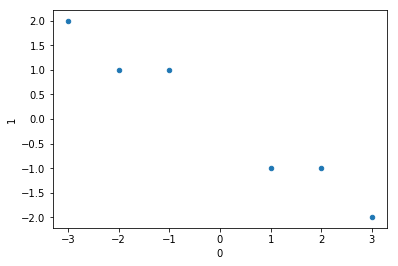

In [82]:
# plot the data
X_df.plot.scatter(x=0, y=1)

(-2, 2)

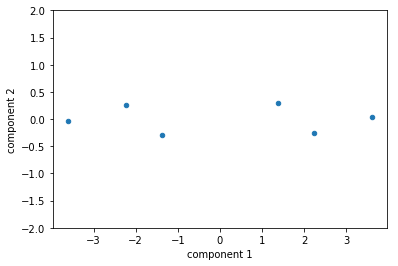

In [84]:
# plot the prinipal components
pca_df.plot.scatter(x='component 1', y='component 2')

# increase range of y-axis to match the original visualization
plt.ylim(-2,2)

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

In [85]:
print('Singular values: {}'.format(pca.singular_values_.round(2)))

# Singular Values are the l2 norm of each component
# e.g. np.sqrt(sum([i**2 for i in pca_df['component 1']]))
print('Singluar Value 1: {}'.format(np.linalg.norm(pca_df['component 1'], ord=2).round(2)))
print('Singluar Value 2: {}'.format(np.linalg.norm(pca_df['component 2'], ord=2).round(2)))

print('\nExplained variance ratio: {}'.format(pca.explained_variance_ratio_))

Singular values: [6.3  0.55]
Singluar Value 1: 6.3
Singluar Value 2: 0.55

Explained variance ratio: [0.99244289 0.00755711]


##### Manually create the first singular value

In [86]:
# view the first prinicipal component
pca_df['component 1']

0    1.383406
1    2.221898
2    3.605304
3   -1.383406
4   -2.221898
5   -3.605304
Name: component 1, dtype: float64

In [87]:
# square all values
pca_df['component 1'] ** 2

0     1.913812
1     4.936831
2    12.998215
3     1.913812
4     4.936831
5    12.998215
Name: component 1, dtype: float64

In [88]:
# take the sum of squares
sum(pca_df['component 1'] ** 2)

39.697715603592215

In [89]:
# take the sqaure root of the sum of squares
np.sqrt(sum(pca_df['component 1'] ** 2))

6.300612319734664

In [90]:
print('Components:\n {}'.format(pca.components_.round(2)))

Components:
 [[-0.84  0.54]
 [ 0.54  0.84]]


##### Recreate PCA through SVD

In [91]:
# recreate PCA using SVD (we will explain this calculation in the next section)
u,s,vt = np.linalg.svd(X_df, full_matrices=False)

print("singular values =\n {} \n".format(np.round(s, 2)))
print("components =\n {} \n".format(np.round(vt, 2)))

# pca
pd.DataFrame(u*s)

singular values =
 [6.3  0.55] 

components =
 [[ 0.84 -0.54]
 [ 0.54  0.84]] 



,0,1
0,-1.383406,0.293579
1,-2.221898,-0.251335
2,-3.605304,0.042244
3,1.383406,-0.293579
4,2.221898,0.251335
5,3.605304,-0.042244


### Singular Value Decomposition

In linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix.

Let A be an m × n term-document frequency matrix with rank r, r ≤ n. Without loss of generality let m ≥ n hold so that there are more terms than documents. The singular value decomposition of A can be stated succinctly as A = U*Σ*VT,

- U is an m × r orthogonal matrix whose columns make up the left singular vectors
- Σ is an r × r dimensional diagonal matrix whose diagonal elements are termed singular values
- V is an r × n orthogonal matrix whose columns form the right singular vectors of A.

In [92]:
# SVD
Image("../../raw_data/images/svd_graph.png", width=700, height=700)

In [93]:
# SVD
Image("../../raw_data/images/svd3.png", width=400)

### Reduced SVD

The SVD comes in two forms, a full SVD, and a reduced SVD. In NLP, we tend to focus on the reduced SVD, using SVD for dimensionality reduction.

SVD can be viewed as a sum of rank one matrices.The matrix A can then be approximated by choosing any k ≤ r. This generates a rank k matrix, Ak, that is the best rank-k approximation to A in terms of least-squares best fit

SOURCE: ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

In [94]:
# reduced SVD
Image("../../raw_data/images/reduced_svd.png", width=500, height=700)

In [95]:
# SVD
Image("../../raw_data/images/svd2.png", width=700)

In [96]:
# Truncated SVD
# SOURCE: https://www.researchgate.net/figure/Singular-value-decomposition-SVD-and-a-truncated-SVD-matrix_fig1_227060873
Image("../../raw_data/images/truncated_svd.png", width=500)

In [97]:
# SVD
Image("../../raw_data/images/svd4.png", width=700)

##### SVD approximation equation
Equation 1 implies that one can get a rough approximation to A by taking the product of the first singular value with the matrix formed from the outer product of the first column of U with the first column of V . The matrix formed, A1, will be m × n but will be of only rank one. Of all possible matrices, B, of rank one, ||A − B||2 will be smallest when B = A1 holds. One can improve the approximation by forming the product of the second singular value with the outer product of the second columns of U and V , and then adding this result to A1. The resultant matrix, A2, will be the the best rank-two approximation to A. The approximations can be successively improved by repeating the process until k = r holds and the original matrix is produced.

In [98]:
# reduced SVD equation
Image("../../raw_data/images/svd_truncated_equation.png", width=500, height=700)

##### Coursera Course on SVD

SOURCE: https://www.coursera.org/learn/matrix-factorization/lecture/K5NBy/singular-value-decomposition

##### When is the SVD Technique Appropriate?
For most Text Mining problems, the SVD will be entirely appropriate to use. Without a data reduction technique, there will be more variables (terms) available than one can use in a data mining model. Some method must be applied to select an appropriate set from which a text mining solution can be built. Unlike term elimination, the SVD technique allows one to derive significantly fewer variables from the original variables. There are some drawbacks to using the SVD, however. Computationally, the SVD is fairly resource intensive and requires a large amount of RAM. The user must have access to these resources in order for the decomposition to be obtained.

##### How Many Dimensions Should be Used?
The choice for the number of dimensions k to use can be a crucial aspect of many text mining solutions. With too few dimensions, the model will fail to explain prominent relationships in the text. On the other hand, using too many dimensions will add unnecessary noise to the model and make training an effective model nearly impossible. In practice, there is an upper bound of at most a few hundred dimensions from which to build a model. So the user should not need to consider more than this

### SVD in comparision to PCA
Using the below image displaying several documents that contain only two terms (A&B)

**SVD:** draw a line through the points in such a way that the sum of the distances from each point to the line is minimized. The documents can then be perpendicularly projected onto this new line. The circles indicate the locations of the projected documents. This line and the new locations for the documents, can be obtained by using the SVD

**PCA:** Spread the points out as much as possible on this new line to maximize the variance of the points that are projected onto the line. This line is formed by performing Principal Component Analysis

Although based on equivalent procedures, since PCA and TM’s SVD approach operate on different data, they do not produce the same results. Depending on whether the raw data is used or the covariance matrix is used, different vectors will be found as basis vectors for the reduced space

While the PCA component maximizes the variance, the SVD finds the best fitting line in the least-squares sense. Depending on the nature of the data, these two lines may or may not be fairly close to one another. 

In [99]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca.png", width=1000)

In [100]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca2.png", width=700)

### SVD Example

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [102]:
print(texts[0])

['gluten', 'and', 'lymphocytes', 'in', 'coeliac_disease']


In [103]:
# combine tokens from the first few lists into sentences
svd_data = [' '.join(text) for text in texts[0:8]]

# create a document term matrix of the token counts
vect = CountVectorizer(max_features=10, stop_words='english')
dtm = vect.fit_transform(svd_data)

# create a dataframe
vocab = vect.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=vocab)
df

,considered,disease,evidence,including,increased,intent,latency,living,lymphocytes,patients
0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1
5,0,1,0,0,0,0,1,0,0,0
6,1,1,1,0,0,1,0,0,0,1
7,1,1,0,0,0,0,0,1,0,0


In [0]:
# decompose the matrix using SVD
U, s, VT = np.linalg.svd(df, full_matrices=False)
S = np.diag(s)

In [105]:
# what are U, S and V
print("U =\n", np.round(U, decimals=2), "\n")
print("S =\n", np.round(S, decimals=2), "\n")
print("V^T =\n", np.round(VT, decimals=2), "\n")

U =
 [[ 0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.25  0.06 -0.3   0.11  0.    0.19 -0.54  0.71]
 [ 0.43  0.83  0.25 -0.22  0.    0.06  0.13  0.  ]
 [ 0.25  0.06 -0.3   0.11  0.    0.19 -0.54 -0.71]
 [ 0.34 -0.14 -0.1   0.5  -0.    0.58  0.51  0.  ]
 [ 0.27  0.1  -0.52  0.3   0.   -0.7   0.24 -0.  ]
 [ 0.59 -0.41  0.59  0.12  0.   -0.28 -0.19 -0.  ]
 [ 0.38 -0.33 -0.35 -0.75  0.    0.1   0.21  0.  ]] 

S =
 [[3.19 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.65 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.55 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.27 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.88 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.56 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]] 

V^T =
 [[ 0.31  0.79  0.32  0.14  0.14  0.19  0.09  0.12  0.    0.29]
 [-0.45  0.11  0.25  0.5   0.5  -0.25  0.06 -0.2   0.   -0.33]
 [ 0.16 -0.47  0.54  0.16  0.16  0.38 -0.33 -0.22  0.    0.32]
 [-0.5   0.14 -0.08 -0.17 -0.17  0.0

In [106]:
# U is othonormal
# These vectors are orthogonal to one another; form a basis for the reduced space

# each vector is normalized (unit vector)
# multiply by itself returns 1
col1 = np.array([i[0] for i in U])
print(col1, '\n')
print('vector 1: {}'.format(round(col1.dot(col1), 2), '\n'))

col2 = np.array([i[1] for i in U])
print('vector 2: {}'.format(round(col2.dot(col2), 2)))

# and each vector is orthogonal to the other vectors
# multiply different vectors returns 0
print('dot product: {}'.format(round(col1.dot(col2), 2)))

[0.         0.24750611 0.433896   0.24750611 0.33930914 0.27448357
 0.59474541 0.38081712] 

vector 1: 1.0
vector 2: 1.0
dot product: 0.0


In [107]:
# rebuild the original matrix from U,S, and V^T
A2 = np.dot(U, np.dot(S, VT))
print("A2 =\n", A2.round(2))

A2 =
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [-0.  1. -0. -0. -0.  0. -0. -0.  0. -0.]
 [ 0.  1.  1.  1.  1.  0. -0. -0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0. -0. -0.  0.  0.]
 [-0.  1. -0. -0. -0. -0.  0. -0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  1. -0.  0.  0.]
 [ 1.  1.  1. -0. -0.  1.  0.  0.  0.  1.]
 [ 1.  1. -0. -0. -0. -0.  0.  1.  0. -0.]]


In [108]:
# example of np.zero_like
np.zeros_like(S)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [109]:
# S_reduced is the same as S but with only the top n elements kept
S_reduced = np.zeros_like(S)

# only keep top few eigenvalues
eigen_num = 3
S_reduced[:eigen_num, :eigen_num] = S[:eigen_num,:eigen_num]

# show S_rediced which has less info than original S
print("S_reduced =\n", S_reduced.round(2))

S_reduced =
 [[3.19 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.65 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.55 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [110]:
# reduce VT by S_reduced
S_reduced_VT = np.dot(S_reduced, VT)
print("S_reduced_VT = \n", S_reduced_VT.round(2))

S_reduced_VT = 
 [[ 0.98  2.52  1.03  0.43  0.43  0.59  0.27  0.38  0.    0.93]
 [-0.74  0.17  0.42  0.83  0.83 -0.41  0.1  -0.33  0.   -0.55]
 [ 0.25 -0.74  0.84  0.25  0.25  0.59 -0.52 -0.35  0.    0.49]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [111]:
# each Singular Value vector is a linear combination of original words
U_S_reduced = np.dot(U, S_reduced)
df = pd.DataFrame(U_S_reduced.round(2), index=vocab[0:8])

# show colour coded so it is easier to see significant word contributions to a topic
df.style.background_gradient(cmap=plt.get_cmap('Blues'))

,0,1,2,3,4,5,6,7
considered,0,0,0,0,0,0,0,0
disease,0.79,0.11,-0.47,0,0,0,0,0
evidence,1.38,1.36,0.39,0,0,0,0,0
including,0.79,0.11,-0.47,0,0,0,0,0
increased,1.08,-0.23,-0.16,0,0,0,0,0
intent,0.88,0.17,-0.81,0,0,0,0,0
latency,1.9,-0.68,0.92,0,0,0,0,0
living,1.21,-0.55,-0.54,0,0,0,0,0


In [112]:
# recreate using sklearn (explained below)
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=3)
tsvd.fit_transform(df).round(2)

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.79,  0.11, -0.47],
       [ 1.38,  1.36,  0.4 ],
       [ 0.79,  0.11, -0.47],
       [ 1.08, -0.23, -0.16],
       [ 0.88,  0.18, -0.81],
       [ 1.9 , -0.69,  0.91],
       [ 1.21, -0.54, -0.55]])

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

##### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

##### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation to the term-document matrix. There could be various reasons for these approximations:

**The original term-document matrix is presumed too large for the computing resources:** in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
**The original term-document matrix is presumed noisy:** for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


##### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* **Synonymy** is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* **Polysemy** is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

##### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

In [0]:
from sklearn.decomposition import TruncatedSVD

In [114]:
# review data
svd_data[0]

'gluten and lymphocytes in coeliac_disease'

In [115]:
# vectorize the text with TFIDF
vect = TfidfVectorizer(max_features=10)
fit_vect = vect.fit_transform(svd_data)
pd.DataFrame(fit_vect.toarray(), columns=vect.get_feature_names())

,and,disease,evidence,in,of,patients,the,to,were,with
0,0.707107,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.311905,0.219577,0.000000,0.000000,0.276089,0.000000,0.623809,0.000000,0.000000,0.623809
2,0.241659,0.170125,0.319405,0.000000,0.427819,0.000000,0.724976,0.319405,0.000000,0.000000
3,0.000000,0.209618,0.000000,0.297757,0.263566,0.000000,0.893271,0.000000,0.000000,0.000000
4,0.000000,0.270504,0.000000,0.384245,0.340123,0.507865,0.000000,0.000000,0.507865,0.384245
5,0.485497,0.341784,0.000000,0.485497,0.000000,0.000000,0.000000,0.641692,0.000000,0.000000
6,0.000000,0.181519,0.340799,0.000000,0.684710,0.340799,0.000000,0.000000,0.000000,0.515689
7,0.000000,0.341784,0.000000,0.000000,0.000000,0.000000,0.485497,0.000000,0.641692,0.485497


Dimensionality reduction using TruncatedSVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

SOURCE: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [116]:
# retain one component
tsvd = TruncatedSVD(n_components=1)
tsvd.fit_transform(fit_vect)

array([[0.3656463 ],
       [0.87325857],
       [0.79651384],
       [0.77200827],
       [0.6589513 ],
       [0.4560151 ],
       [0.62479051],
       [0.72815071]])

In [117]:
# retain two components
tsvd = TruncatedSVD(n_components=2)
tsvd.fit_transform(fit_vect)

array([[ 0.3656463 ,  0.83319322],
       [ 0.87325857, -0.16399002],
       [ 0.79651384,  0.01239985],
       [ 0.77200827, -0.02977881],
       [ 0.6589513 , -0.08168182],
       [ 0.4560151 ,  0.78662793],
       [ 0.62479051, -0.34524357],
       [ 0.72815071, -0.32619683]])

# LDA (Latent dirichlet allocation)

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

- (0.6, 0.4)
- (0.1, 0.1, 0.8)
- (0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: 
- [What is an intuitive explanation of the Dirichlet distribution?](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution)
- [VIDEO: Digging into the Dirichlet Distribution](https://www.hakkalabs.co/articles/the-dirichlet-distribution)
- [Introduction to Latent Dirichlet Allocation:](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)
- [Gensim LDA: Tips and Tricks](https://miningthedetails.com/blog/python/lda/GensimLDA/)

In [0]:
from gensim.models.ldamodel import LdaModel

In [0]:
# Set up log to terminal
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set up log to external log file
# logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [120]:
%%time

# create a lda model
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=10
    , id2word=dictionary
    , passes=20
)

2019-06-01 00:56:02,333 : INFO : using symmetric alpha at 0.1
2019-06-01 00:56:02,336 : INFO : using symmetric eta at 0.1
2019-06-01 00:56:02,341 : INFO : using serial LDA version on this node
2019-06-01 00:56:02,376 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 12446 documents, updating model once every 2000 documents, evaluating perplexity every 12446 documents, iterating 50x with a convergence threshold of 0.001000
2019-06-01 00:56:02,378 : INFO : PROGRESS: pass 0, at document #2000/12446
2019-06-01 00:56:02,843 : INFO : merging changes from 2000 documents into a model of 12446 documents
2019-06-01 00:56:02,863 : INFO : topic #8 (0.100): 0.006*"the" + 0.005*"with" + 0.005*"in" + 0.005*"and" + 0.005*"to" + 0.005*"of" + 0.004*"were" + 0.004*"patients" + 0.004*"for" + 0.004*"whipple_disease"
2019-06-01 00:56:02,866 : INFO : topic #5 (0.100): 0.007*"patients" + 0.006*"with" + 0.006*"the" + 0.005*"in" + 0.005*"and" + 0.005*"of" + 0.00

CPU times: user 51.1 s, sys: 1.72 s, total: 52.9 s
Wall time: 52.7 s


In [121]:
# view the output of the first vector
ldamodel[tfidf_vect[0]]

[(0, 0.035190914),
 (1, 0.03519029),
 (2, 0.03521713),
 (3, 0.03519017),
 (4, 0.035208624),
 (5, 0.035190135),
 (6, 0.45396605),
 (7, 0.26446643),
 (8, 0.035189807),
 (9, 0.035190474)]

In [122]:
# extract the lda output of all vectors and store as a dataframe
lda_data = ([score[1] for score in lda] for lda in ldamodel[tfidf_vect])
pd.DataFrame(lda_data)

,0,1,2,3,4,5,6,7,8,9
0,0.035191,0.035191,0.249066,0.035190,0.035204,0.035190,0.469380,0.035207,0.035190,0.035191
1,0.021276,0.021275,0.021279,0.021275,0.159939,0.021275,0.107678,0.500667,0.104058,0.021277
2,0.017064,0.120073,0.017076,0.017064,0.078856,0.017066,0.274714,0.423894,0.017123,0.017070
3,0.097696,0.022368,0.022378,0.022367,0.022369,0.022367,0.022368,0.723348,0.022367,0.022372
4,0.145115,0.025433,0.025436,0.025433,0.025435,0.241757,0.025433,0.435090,0.025433,0.025434
5,0.026826,0.026835,0.290621,0.494732,0.026830,0.026826,0.026830,0.026846,0.026826,0.026826
6,0.024393,0.024389,0.024401,0.240931,0.235633,0.024390,0.024390,0.352692,0.024390,0.024390
7,0.024296,0.247387,0.439238,0.024293,0.143298,0.024299,0.024293,0.024305,0.024296,0.024294
8,0.024037,0.024041,0.024037,0.024034,0.024035,0.279195,0.024035,0.528506,0.024034,0.024048
9,0.128575,0.279199,0.024773,0.024769,0.024771,0.024770,0.024769,0.418836,0.024768,0.024768


In [123]:
# view the topics
ldamodel.print_topics(num_topics=10, num_words=5)

2019-06-01 00:56:57,793 : INFO : topic #0 (0.100): 0.006*"alpha_hydroxyvitamin" + 0.006*"zinc" + 0.005*"occlusive" + 0.005*"in" + 0.005*"thyroid"
2019-06-01 00:56:57,795 : INFO : topic #1 (0.100): 0.007*"pancreatic" + 0.006*"bone" + 0.006*"ray" + 0.005*"involved" + 0.004*"frequent"
2019-06-01 00:56:57,797 : INFO : topic #2 (0.100): 0.011*"the" + 0.009*"virus" + 0.008*"of" + 0.008*"and" + 0.007*"in"
2019-06-01 00:56:57,799 : INFO : topic #3 (0.100): 0.007*"case_report" + 0.006*"paget_disease" + 0.005*"half" + 0.005*"entity" + 0.005*"external"
2019-06-01 00:56:57,800 : INFO : topic #4 (0.100): 0.006*"graves_disease" + 0.005*"with" + 0.005*"in" + 0.005*"patients" + 0.005*"and"
2019-06-01 00:56:57,802 : INFO : topic #5 (0.100): 0.007*"coronary" + 0.006*"proceedings" + 0.006*"care" + 0.005*"infant" + 0.005*"regional"
2019-06-01 00:56:57,804 : INFO : topic #6 (0.100): 0.005*"coeliac_disease" + 0.005*"newcastle_disease" + 0.004*"motor" + 0.004*"left" + 0.004*"risk_factors"
2019-06-01 00:56:57

[(0,
  '0.006*"alpha_hydroxyvitamin" + 0.006*"zinc" + 0.005*"occlusive" + 0.005*"in" + 0.005*"thyroid"'),
 (1,
  '0.007*"pancreatic" + 0.006*"bone" + 0.006*"ray" + 0.005*"involved" + 0.004*"frequent"'),
 (2, '0.011*"the" + 0.009*"virus" + 0.008*"of" + 0.008*"and" + 0.007*"in"'),
 (3,
  '0.007*"case_report" + 0.006*"paget_disease" + 0.005*"half" + 0.005*"entity" + 0.005*"external"'),
 (4,
  '0.006*"graves_disease" + 0.005*"with" + 0.005*"in" + 0.005*"patients" + 0.005*"and"'),
 (5,
  '0.007*"coronary" + 0.006*"proceedings" + 0.006*"care" + 0.005*"infant" + 0.005*"regional"'),
 (6,
  '0.005*"coeliac_disease" + 0.005*"newcastle_disease" + 0.004*"motor" + 0.004*"left" + 0.004*"risk_factors"'),
 (7, '0.016*"the" + 0.010*"to" + 0.010*"with" + 0.010*"of" + 0.009*"in"'),
 (8,
  '0.006*"sarcoidosis" + 0.006*"areas" + 0.005*"organs" + 0.005*"respiratory_disease" + 0.005*"dogs"'),
 (9,
  '0.006*"vaccine" + 0.006*"iron" + 0.006*"influenza" + 0.005*"functional" + 0.005*"periodontal_disease"')]

### pyLDAvis
pyLDAvis is a python libarary for interactive topic model visualization. It is a port of the fabulous R package by Carson Sievert and Kenny Shirley. They did the hard work of crafting an effective visualization. pyLDAvis makes it easy to use the visualiziation from Python and, in particualr, IPython notebooks. To learn more about the method behind the visualization I suggest reading the original paper explaining it.

- **conda install pyldavis**


In [124]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='tsne')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      -88.532349 -110.169968       1        1  53.276070
2     -431.113312  -86.920723       2        1  17.465567
4       78.398560 -409.967041       3        1   6.267995
0     -107.365631  423.816803       4        1   4.238694
9      225.940659  386.298859       5        1   3.817120
1     -254.927475 -372.328308       6        1   3.308257
5      402.223206  100.898041       7        1   3.117241
6     -277.352509  173.592117       8        1   3.100765
8      248.825668 -159.933380       9        1   3.055950
3       59.867859  123.933609      10        1   2.352339, topic_info=     Category         Freq  ...  loglift  logprob
1412  Default   502.000000  ...  30.0000  30.0000
67    Default  1407.000000  ...  29.0000  29.0000
3     Default  1696.000000  ...  28.0000  28.0000
1348  Default   239.000000  ...  27.0000  27.0000
234   Default   790.000000  ...  26.0000  26.0000
327   Default   395.000000  ...  25.0000  25.0000
1     Default   159.000000  ...  24.0000  24.0000
21    Default  1672.000000  ...  23.0000  23.0000
4605  Default   166.000000  ...  22.0000  22.0000
431   Default   322.000000  ...  21.0000  21.0000
1553  Default   266.000000  ...  20.0000  20.0000
811   Default   146.000000  ...  19.0000  19.0000
0     Default  1643.000000  ...  18.0000  18.0000
9     Default  1095.000000  ...  17.0000  17.0000
116   Default   549.000000  ...  16.0000  16.0000
624   Default   284.000000  ...  15.0000  15.0000
313   Default   882.000000  ...  14.0000  14.0000
655   Default   217.000000  ...  13.0000  13.0000
362   Default   308.000000  ...  12.0000  12.0000
54    Default  1002.000000  ...  11.0000  11.0000
45    Default  1597.000000  ...  10.0000  10.0000
69    Default   957.000000  ...   9.0000   9.0000
335   Default   351.000000  ...   8.0000   8.0000
17    Default   529.000000  ...   7.0000   7.0000
1171  Default   310.000000  ...   6.0000   6.0000
2258  Default   210.000000  ...   5.0000   5.0000
787   Default   425.000000  ...   4.0000   4.0000
847   Default   126.000000  ...   3.0000   3.0000
895   Default    96.000000  ...   2.0000   2.0000
42    Default   967.000000  ...   1.0000   1.0000
...       ...          ...  ...      ...      ...
9553  Topic10    15.538151  ...   3.5715  -5.8687
1762  Topic10    15.325538  ...   3.5694  -5.8824
745   Topic10    15.056095  ...   3.5664  -5.9002
4479  Topic10    15.000531  ...   3.5658  -5.9039
1543  Topic10    14.788138  ...   3.5634  -5.9181
2001  Topic10    14.622559  ...   3.5615  -5.9294
5942  Topic10    14.603834  ...   3.5613  -5.9307
2399  Topic10    13.326940  ...   3.5449  -6.0222
7063  Topic10    13.223969  ...   3.5435  -6.0299
3431  Topic10    13.195374  ...   3.5431  -6.0321
4167  Topic10    13.094522  ...   3.5416  -6.0398
4857  Topic10    13.076947  ...   3.5413  -6.0411
3741  Topic10    12.841186  ...   3.5379  -6.0593
6976  Topic10    12.736035  ...   3.5364  -6.0675
5840  Topic10    12.411578  ...   3.5314  -6.0933
5199  Topic10    12.336795  ...   3.5302  -6.0994
3103  Topic10    12.276262  ...   3.5292  -6.1043
2339  Topic10    29.460848  ...   3.5235  -5.2289
2397  Topic10    19.973475  ...   3.5028  -5.6176
1795  Topic10    17.903065  ...   3.4888  -5.7270
4985  Topic10    28.889629  ...   3.4220  -5.2485
3016  Topic10    33.048534  ...   2.9049  -5.1140
1153  Topic10    24.299343  ...   2.9692  -5.4215
337   Topic10    24.703434  ...   2.8847  -5.4050
6670  Topic10    17.909000  ...   2.8656  -5.7267
4077  Topic10    20.871023  ...   2.2979  -5.5736
3226  Topic10    16.075123  ...   2.8587  -5.8347
1042  Topic10    18.698837  ...   2.2220  -5.6835
811   Topic10    18.469133  ...   1.6790  -5.6959
2055  Topic10    15.964031  ...   2.6557  -5.8416

[546 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
786       1  0.016617             ab

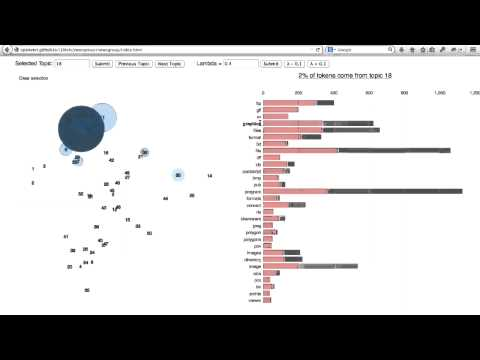

In [125]:
YouTubeVideo('IksL96ls4o0', width=800, height=400)

## Visdom

Install it with:

`conda install visdom`

Start the server:

`python -m visdom.server`

Visdom now can be accessed at http://localhost:8097 in the browser.


##### METRICS:
**DiffMetric** calculates the distance between two LDA models. This distance is calculated based on the topics, by either using their probability distribution over vocabulary words (**kullback_leibler**, hellinger) or by simply using the common vocabulary words between the topics from both model.

In the heatmap, X-axis define the Epoch no. and Y-axis define the distance between identical topics from consecutive epochs. For ex. a particular cell in the heatmap with values (x=3, y=5, z=0.4) represent the distance(=0.4) between the topic 5 from 3rd epoch and topic 5 from 2nd epoch. With increasing epochs, the distance between the identical topics should decrease.

SOURCE: 
- [LDA Training Visualization](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Training_visualizations.ipynb)
- [Visdom](https://github.com/facebookresearch/visdom)
- [Training and Topic visualizations in gensim](https://rare-technologies.com/paruls-gsoc-2017-summary-training-and-topic-visualizations-in-gensim/)
- [OptimizingSemanticCoherenceinTopicModels](https://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf)

In [126]:
from gensim.models.callbacks import DiffMetric
from gensim.models.callbacks import CoherenceMetric

# callback methods
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="kullback_leibler")
hellinger = DiffMetric(distance="hellinger", logger="visdom", title="hellinger")
jaccard = DiffMetric(distance="jaccard", logger="visdom", title="jaccard")


# training LDA model
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=20
    , id2word=dictionary
    , passes=180
    , callbacks=[diff_kl, hellinger, jaccard]
)

2019-06-01 01:05:01,174 : INFO : using symmetric alpha at 0.05
2019-06-01 01:05:01,176 : INFO : using symmetric eta at 0.05
2019-06-01 01:05:01,180 : INFO : using serial LDA version on this node
2019-06-01 01:05:01,217 : INFO : running online (multi-pass) LDA training, 20 topics, 180 passes over the supplied corpus of 12446 documents, updating model once every 2000 documents, evaluating perplexity every 12446 documents, iterating 50x with a convergence threshold of 0.001000


ImportError: ignored

In [0]:
# visdom UI
Image("../../raw_data/images/visdom_graph.png", width=800)